In [2]:
import pandas as pd

checkins = pd.read_csv('comboframe.csv', usecols=['beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name',
                                                  'beer_style', 'beer_name',
                                                  'checkin_id'])
# only allow each user one rating for each beer
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)
print(checkins.shape)

(1894852, 9)


In [3]:
# remove the users who only checked fewer than 4 times
checkins = checkins[checkins.user_id.map(checkins.groupby('user_id').size() > 3)]
checkins.shape

(1529580, 9)

In [4]:
# remove the beers rated fewer than 4 times
checkins = checkins[checkins.beer_id.map(checkins.groupby('beer_id').size() > 3)]
checkins.shape

(1257869, 9)

In [5]:
# remove the ones with no global ratings
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)
# and the zeros
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(1193682, 9)

In [6]:
# remove beers that aren't really beer, based on the alcohol content
checkins = checkins[(checkins.abv > 0) & (checkins.abv < 20)]
checkins.shape

(1184752, 9)

In [7]:
checkins.head(2)

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5
1,818949121,1709568,3340203,3.50,Ritual Brewing Company,Pale Ale,Pale Ale - American,3.43165,5.2


In [8]:
# a mapping from user to number of ratings can be helpful in many situations
usercounts = checkins.groupby('user_id').size()

In [9]:
def split_last_X(frame, countDict, X):
    '''
    Split the input frame into training and testing,
    using the last X for each user as testers.
    CountDict input has the rows per user,
    and the frame is indexed by user.
    Returns the train split and test split
    '''
    boollist = [[True] * (countDict[u] - X) + [False] * X for u in frame.index.unique()]
    boollist = np.array([boo for lis in boollist for boo in lis])  # numpy to help with the logic
    
    return frame[boollist], frame[~boollist]

In [10]:
# make a func to deal with ties in rankings
def untied_rank(arr, vals):
    '''
    Measure how well the input vals (list or np.array) has chosen
    the top values of input arr (np.array). 
    vals must be subset of arr.
    1.0 is perfect, 0.0 is worst.
    '''
    fails = 0
    poss_fails = 0
    ordered = np.sort(arr)
    if max(ordered) == min(ordered): return 0.5  # like guessing
    for i in range(len(vals)):
        fails += sum(arr > vals[i])
        arr = np.delete(arr, np.where(arr == vals[i])[0][0])
        poss_fails += sum(ordered > ordered[i])
    
    return 1 - fails / poss_fails

In [82]:
untied_rank(np.array([2,3,2,2]), [4,3])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [1]:
import numpy as np

In [11]:
# with sorted checkins for each user, we can simulate having a user's rating history when recommending
checkins.sort_values(by=['user_id', 'checkin_id'], inplace=True)
checkins.set_index('user_id', inplace=True)
# gather the users who have more than 50 ratings and save their last 10 for testing
bigs = checkins.index.map(usercounts) > 49
smalls = checkins[~bigs]
tr, test = split_last_X(checkins[bigs], usercounts, 10)
train = pd.concat([smalls, tr])
print(f'{train.shape[0]} training rows, {test.shape[0]} testing rows')

1112372 training rows, 72380 testing rows


In [12]:
# need the space
checkins = None

Get the baseline score of recommending top-rated beers, regardless of user.

In [17]:
# baseline (top picks) results/target
top_rank_scores = []
for u in test.index.unique():
    utest = test.loc[u, ['rating_user','rating_global']]
    top_rank_scores.append(untied_rank(utest.rating_user.values, 
                              utest.rating_user.values[np.argsort(utest.rating_global.values)[:-4:-1]]))
print(f'The average score picking the top 3 globally rated for {len(top_rank_scores)} "menus":  {np.mean(top_rank_scores)}')

The average score picking the top 3 globally rated for 7238 "menus":  0.7752973184428179


Now see where collaborative filtering can get us.

In [13]:
from tqdm import tqdm

In [14]:
from collections import defaultdict

In [15]:
# show how each user's ratings deviate from global ratings and from their own ratings
train['udiff'] = train.rating_user - train.rating_global
train['udev'] = train.udiff - train.index.map(train.groupby(train.index)['udiff'].mean())

In [16]:
train.reset_index(inplace=True)
udict = {uid:dict() for uid in train.user_id.unique()}
bdict = {bid:dict() for bid in train.beer_id.unique()}
for checkin in zip(train.user_id, train.beer_id, train.udev):
    udict[checkin[0]][checkin[1]] = checkin[2]
    bdict[checkin[1]][checkin[0]] = checkin[2]

In [34]:
# in order to pickle the default dict, use this instead of a lambda:
def dd():
    return defaultdict(float)

# calculate user/user correlation/similarity 
shared = {u: defaultdict(dd) for u in udict}
# this may take a minute or maybe an hour, depending on memory, with the nested loops, but seems messy otherwise
for u in tqdm(udict):
    # loop thru all checkins by u
    for b in udict[u]:
        # update the similarity factors for u-v for every checkin, as would happen with new checkins
        for v in bdict[b]:
            suv = shared[u][v]
            suv['count'] += 1  # increment the common u-v ratings
            #### stats.stackexchange has these going last, but then each new sample
            ##### updates to a diff from mean that it contributes to, which seems wrong
            ###### (and messes up the first one, where u_bar == u[b])  ####
            u_dev = udict[u][b] - suv['u_bar']
            v_dev = udict[v][b] - suv['v_bar']
            suv['numer'] += u_dev * v_dev
            suv['denom_1'] += u_dev ** 2
            suv['denom_2'] += v_dev ** 2
            #####
            suv['u_bar'] = ((suv['count']-1) * suv['u_bar'] + udict[u][b]) / suv['count']
            suv['v_bar'] = ((suv['count']-1) * suv['v_bar'] + udict[v][b]) / suv['count']
    # too much data for this notebook's memory to hold, so let's start by 
    ## filtering out user/user pairs with < 5 common beers (this shouldn't be done here, but space is needed)
    for v in shared[u]:
        if shared[u][v]['count'] < 5:
            shared[u][v] = []
    # remove self-edges
    del shared[u][u]

100%|██████████| 43641/43641 [14:08<00:00, 16.06it/s]   


In [38]:
print(len([v for v in shared[89] if shared[89][v] and shared[89][v]['count'] > 4]))
print(len(shared[2680]))

766
5459


In [37]:
import pickle
# get this thing saved, since the memory required to build it is not always available
with open('suvdict.pkl', 'wb') as f:
    pickle.dump(shared, f)

KeyboardInterrupt: 

In [39]:
# easier just to have this dict sitting by and ready to use
userbiasdict = dict(train.groupby('user_id').udiff.mean())

In [40]:
# the global rating for each beer differs slightly from checkin to checkin,
## due to accumulating stats over time.  Also I'm using each beer's listed
## global rating mean, instead of the mean of all global ratings...
beer_mu = dict(train.groupby('beer_id').rating_global.mean())

In [41]:
test.index

Int64Index([     89,      89,      89,      89,      89,      89,      89,
                 89,      89,      89,
            ...
            7245674, 7245674, 7245674, 7245674, 7245674, 7245674, 7245674,
            7245674, 7245674, 7245674],
           dtype='int64', name='user_id', length=72380)

In [42]:
test.reset_index(inplace=True)

In [361]:

preds = []
basers = []
actual = []
lam_4 = 1e-4  # higher value for this shrinks the prediction's deviation towards the global mean,
            ## especially for u-v combos with fewer common beers
k = 10
eps = 1e-4  # avoids div by zero and also shrinks deviation from global mean for predictions
min_shared_beers = 30  # this only starts to help around 20+, otherwise it's just noise
min_abs_corr = 0.2  # how similar or dissimilar does user v have to be to user u, in order to have a say

for row in tqdm(zip(test.user_id, test.beer_id, test.rating_user)):
    try:
        x = row[1]
        u = row[0]
        # before adding any tweaks, what's the baseline?
        baseline = beer_mu[x] + userbiasdict[u]  # this alone scores 0.4371 RMSE
        
        # only looking for users v who rated the beer x in question
        uv = [v for v in bdict[x] if v in shared[u] and len(shared[u][v]) and
              shared[u][v]['count'] >= min_shared_beers] # threshold for common beers rated
        suv = [shared[u][v] for v in uv]
        if not suv:
            basers.append(baseline)
            preds.append(baseline)
            actual.append(row[2])
            continue
        
        # first get u-v pearsons
        ## https://stats.stackexchange.com/questions/410468/online-update-of-pearson-coefficient
        sims = [s['numer'] / np.sqrt(s['denom_1'] * s['denom_2'])
                    for s in suv if len(s) ]  # need to filter out empty list s's
        # then shrink in inverse relation to number of common u-v ratings
        sims = np.multiply(np.array(sims),
                           np.array([s['count'] / (s['count'] + lam_4) 
                                     for s in suv if len(s)]))
        most_sim = sorted(list(zip(uv, sims)), reverse=True, key=lambda x: abs(x[1]))
        # take the k most similar/opposite, or all for the many short lists
        most_sim = most_sim[:min(k, len(most_sim))]
        tweaks = [udict[sim[0]][x] * sim[1] for sim in most_sim if abs(sim[1]) > min_abs_corr]
        tweak = sum(tweaks) / (len(tweaks) + eps)
        preds.append(baseline + tweak)
        basers.append(baseline)
        actual.append(row[2])
    except KeyError:
        basers.append(baseline)
        preds.append(baseline)
        actual.append(row[2])
        continue

diffs = np.array(preds) - np.array(actual)
rmse = np.sqrt(np.dot(diffs, diffs) / len(diffs))
rmse

72380it [01:01, 1180.35it/s]


0.43542932256195488

In [362]:
dees = np.array(preds) - np.array(basers)
nonbase = dees != 0
sum(nonbase)

1446

In [363]:
diff_actuals = np.array(actual)[nonbase]
diff_preds = np.array(preds)[nonbase]
diff_basers = np.array(basers)[nonbase]
len(diff_actuals) == len(diff_preds) == len(diff_basers)

True

In [364]:
pred_acts = diff_preds - diff_actuals
base_acts = diff_basers - diff_actuals
pred_rmse = np.sqrt(np.dot(pred_acts, pred_acts) / len(pred_acts))
print(pred_rmse)
base_rmse = np.sqrt(np.dot(base_acts, base_acts) / len(base_acts))
print(base_rmse)

0.366800113605
0.386856045364


In [334]:
tweak_df = test[nonbase]

In [335]:
tweak_df.user_id.nunique()

836

In [336]:
len(tweak_df)

2310

In [365]:
scores = []
bases = []
for i in range(test.user_id.nunique()):
    udf = test.iloc[10*i: 10*(i+1), :]
    scores.append(untied_rank(udf.rating_user.values, 
                              udf.rating_user.values[np.argsort(preds[10*i: 10*(i+1)])[:-4:-1]]))
    bases.append(untied_rank(udf.rating_user.values, 
                              udf.rating_user.values[np.argsort(udf.rating_global.values)[:-4:-1]]))

print(f'The average score picking the top 3 predicted for {len(scores)} "menus":  {np.mean(scores)}')
print(f'And the average score using global means: {np.mean(bases)}')

The average score picking the top 3 globally rated for 7238 "menus":  0.7755099418471806
And the average score using global means: 0.7752973184428179


In [366]:
new_scores = np.array(scores) != np.array(bases)
print(f'The average score for the baseline prediction when the tweaked version was different: \
        {np.mean(np.array(bases)[new_scores])}')
print(f'And the average score for the tweaked scores: {np.mean(np.array(scores)[new_scores])}')


The average score for the baseline prediction when the tweaked version was different:         0.7563623131747779
And the average score for the tweaked scores: 0.7502064403716712


In [367]:
print(f'no tweak: {sum(np.array(scores) == np.array(bases))}')
print(f'tweak helped: {sum(np.array(scores) > np.array(bases))}')
print(f'tweak hurt: {sum(np.array(scores) < np.array(bases))}')

no tweak: 6988
tweak helped: 135
tweak hurt: 115


Basically, the signal coming from correlated users is just noise.  
Taking users with 25+ commonly rated beers does show a small improvement.

In [371]:
def score_frame(df, beer_mu, ubias_dict, share_dict, udict, 
                penalty, k_most_sim, eps, min_shared, min_abs_corr):
    preds = []
    basers = []
    actual = []
    lam_4 = penalty  # higher value for this shrinks the prediction's deviation towards the global mean,
            ## especially for u-v combos with fewer common beers
    k = k_most_sim
    eps = eps  # avoids div by zero and also shrinks deviation from global mean for predictions
    min_shared_beers = min_shared  # this only starts to help around 20+, otherwise it's just noise
    min_abs_corr = min_abs_corr  # how similar or dissimilar does user v have to be to user u, in order to have a say

    for row in tqdm(zip(df.user_id, df.beer_id, df.rating_user)):
        try:
            x = row[1] # beer
            u = row[0] # user
            # before adding any tweaks, what's the baseline?
            baseline = beer_mu[x] + ubias_dict[u]  # this alone scores 0.4371 RMSE
        
            # only looking for users v who rated the beer x in question
            uv = [v for v in bdict[x] if v in share_dict[u] and len(share_dict[u][v]) and
              share_dict[u][v]['count'] >= min_shared_beers] # threshold for common beers rated
            suv = [share_dict[u][v] for v in uv]
            if not suv:
                basers.append(baseline)
                preds.append(baseline)
                actual.append(row[2])
                continue
        
            # first get u-v pearsons
            ## https://stats.stackexchange.com/questions/410468/online-update-of-pearson-coefficient
            sims = [s['numer'] / np.sqrt(s['denom_1'] * s['denom_2'])
                    for s in suv if len(s) ]  # need to filter out empty list s's
            # then shrink in inverse relation to number of common u-v ratings
            sims = np.multiply(np.array(sims),
                               np.array([s['count'] / (s['count'] + lam_4) 
                               for s in suv if len(s)]))
            most_sim = sorted(list(zip(uv, sims)), reverse=True, key=lambda x: abs(x[1]))
            # take the k most similar/opposite, or all for the many short lists
            most_sim = most_sim[:min(k, len(most_sim))]
            tweaks = [udict[sim[0]][x] * sim[1] for sim in most_sim if abs(sim[1]) > min_abs_corr]
            tweak = sum(tweaks) / (len(tweaks) + eps)
            preds.append(baseline + tweak)
            basers.append(baseline)
            actual.append(row[2])
        except KeyError:
            basers.append(baseline)
            preds.append(baseline)
            actual.append(row[2])
            continue

    diffs = np.array(preds) - np.array(actual)
    rmse = np.sqrt(np.dot(diffs, diffs) / len(diffs))
    # don't really need to return rmse, since preds and actual can calculate it, but....
    return rmse, np.array(preds), np.array(basers), np.array(actual)

In [377]:
rmses = []
p_rmses = []
b_rmses = []
# start with 5 minimum common rated beers as a threshold and move up to 35
for n in range(5,36,3):
    # set epsilon, penalty, and min_abs_correlation to 0.1, for when n is higher
    rmse, preds, basers, actual = score_frame(test, beer_mu, userbiasdict, shared,
                                             udict, 1e-1, 10, 1e-1, n, 1e-1)
    rmses.append(rmse)
    nonbase = preds != basers 
    diff_actuals = actual[nonbase]
    diff_preds = preds[nonbase]
    diff_basers = basers[nonbase]
    pred_acts = diff_preds - diff_actuals
    base_acts = diff_basers - diff_actuals
    pred_rmse = np.sqrt(np.dot(pred_acts, pred_acts) / len(pred_acts))
    p_rmses.append(pred_rmse)
    base_rmse = np.sqrt(np.dot(base_acts, base_acts) / len(base_acts))
    b_rmses.append(base_rmse)

72380it [01:19, 910.65it/s] 
72380it [00:53, 1365.27it/s]
72380it [00:31, 2274.53it/s]
72380it [00:27, 2655.20it/s]
72380it [00:27, 2663.55it/s]
72380it [00:32, 2247.12it/s]
72380it [00:28, 2560.51it/s]
72380it [00:24, 2949.21it/s]
72380it [00:24, 2961.31it/s]
72380it [00:23, 3064.07it/s]
72380it [00:29, 2436.86it/s]


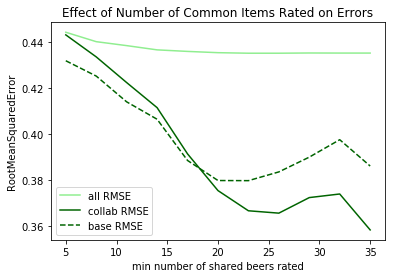

In [378]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(5,36,3), rmses, color='lightgreen', label='all RMSE')
plt.plot(range(5,36,3), p_rmses, color='darkgreen', label='collab RMSE')
plt.plot(range(5,36,3), b_rmses, '--', color='darkgreen', label='base RMSE')
plt.xlabel('min number of shared beers rated')
plt.ylabel('RootMeanSquaredError')
plt.title('Effect of Number of Common Items Rated on Errors')
plt.legend();


Let's look at 35 minimum shared ratings to see how the collaborative filtering tweak helped

In [379]:
r35, p35, b35, a35 = score_frame(test, beer_mu, userbiasdict, shared,
                                             udict, 1e-1, 10, 1e-1, 35, 1e-1)

72380it [01:09, 1037.43it/s]


In [380]:
nonbase = p35 != b35
sum(nonbase)

1321

So only in 1321 out of 72380 ratings was the 35-minimum threshold met, and collaborative filtering came into play.

In [381]:
u35 = test[nonbase].user_id.unique()
len(u35)

455

455 users for those 1321 tweaked ratings, so maybe the order of recommendations changes from the baseline for some of them?

In [354]:
test['preds'] = p35
test['basers'] = b35

In [382]:
test35 = test.set_index('user_id').loc[u35,:]
len(test35)

4550

In [383]:
t = test35.head(10)
t

,checkin_id,beer_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,preds,basers
user_id,,,,,,,,,,
8279,822879983,2480487,4.00,Great Divide Brewing Company,Mexican Chocolate Yeti,Stout - American Imperial / Double,4.17568,9.5,3.902036,4.055862
8279,822886926,2368153,3.75,Ass Clown Brewing Company,Partly Cloudy with a Chance of Fun,IPA - New England,3.91192,6.7,3.792102,3.792102
8279,822898315,607480,3.75,Night Shift Brewing,Whirlpool,Pale Ale - New England,3.88808,4.5,3.768262,3.768262
8279,823138648,2388315,4.00,J. Wakefield Brewing,Chains,IPA - New England,4.17647,6.5,4.056652,4.056652
8279,823143970,3430819,4.00,J. Wakefield Brewing,No Mas,Sour - Gose - Fruited,4.01127,7.0,3.829066,3.891452
8279,823152967,2606937,3.75,Crooked Run,Double Vibes (Blackberry),Sour - Berliner Weisse,3.92647,5.0,3.806652,3.806652
8279,823153194,3482530,4.00,Sun Lab Brewing Co.,Drift Deeper,Sour - Berliner Weisse,4.03498,5.7,3.915162,3.915162
8279,823161544,1861131,3.75,Ardent Craft Ales,Imperial Milk Stout,Stout - Imperial / Double Milk,3.83450,10.0,3.714682,3.714682
8279,837271489,3299217,4.00,Beat Culture Brewery,Vamoose Hazy DIPA,IPA - New England,3.94457,8.1,3.824752,3.824752


In [384]:
t.reset_index()[['beer_name', 'rating_global']].sort_values('rating_global', ascending=False)

,beer_name,rating_global
9,Space Cookie,4.36217
3,Chains,4.17647
0,Mexican Chocolate Yeti,4.17568
6,Drift Deeper,4.03498
4,No Mas,4.01127
8,Vamoose Hazy DIPA,3.94457
5,Double Vibes (Blackberry),3.92647
1,Partly Cloudy with a Chance of Fun,3.91192
2,Whirlpool,3.88808
7,Imperial Milk Stout,3.83450


In [385]:
t.reset_index()[['beer_name', 'rating_user']].sort_values('rating_user', ascending=False)

,beer_name,rating_user
0,Mexican Chocolate Yeti,4.00
3,Chains,4.00
4,No Mas,4.00
6,Drift Deeper,4.00
8,Vamoose Hazy DIPA,4.00
9,Space Cookie,4.00
1,Partly Cloudy with a Chance of Fun,3.75
2,Whirlpool,3.75
5,Double Vibes (Blackberry),3.75
7,Imperial Milk Stout,3.75


In [386]:
t.reset_index()[['beer_name', 'preds']].sort_values('preds', ascending=False)

,beer_name,preds
9,Space Cookie,4.242352
3,Chains,4.056652
6,Drift Deeper,3.915162
0,Mexican Chocolate Yeti,3.902036
4,No Mas,3.829066
8,Vamoose Hazy DIPA,3.824752
5,Double Vibes (Blackberry),3.806652
1,Partly Cloudy with a Chance of Fun,3.792102
2,Whirlpool,3.768262
7,Imperial Milk Stout,3.714682


The third pick changed for the tweaked version, but the accuracy score would've been the same.  
You could argue that the recommender found a different beer for the user, but only by the slimmest of margins here.

In [388]:
glob_scores = []
tweak_scores = []
for u in test35.index.unique():
    uten = test35.loc[u, ['rating_user','rating_global','preds']]
    glob_scores.append(untied_rank(uten.rating_user.values, 
                              uten.rating_user.values[np.argsort(uten.rating_global.values)[:-4:-1]]))
    tweak_scores.append(untied_rank(uten.rating_user.values, 
                              uten.rating_user.values[np.argsort(uten.preds.values)[:-4:-1]]))
print(f'The average score picking the top 3 globally rated for 455 "menus":  {np.mean(glob_scores)}')
print(f'The average score picking the top 3 collab rated for 455 "menus":  {np.mean(tweak_scores)}')

The average score picking the top 3 globally rated for 455 "menus":  0.7945799158340003
The average score picking the top 3 collab rated for 455 "menus":  0.8024770669263444


In [389]:
best_tweak = np.argmax(np.array(tweak_scores) - np.array(glob_scores))
worst_tweak = np.argmax(np.array(glob_scores) - np.array(tweak_scores))
print(best_tweak, worst_tweak)

254 139


##### best tweak results:

In [390]:
t = test.set_index('user_id').loc[u35[best_tweak],:]

Global preds:

In [391]:
t.reset_index()[['beer_name', 'rating_global']].sort_values('rating_global', ascending=False)

,beer_name,rating_global
8,SarahannDIPAty,4.05546
1,Warpath,3.95493
9,Rocket S.H.I.P.A - Cascade,3.77642
7,Basically Famous,3.77273
5,Hopsecutioner,3.76306
3,Up-Hi,3.73544
4,RecreationAle,3.59156
0,Tropical Pale Ale,3.56874
2,IPA,3.49715
6,Florida Avenue Lager,3.45065


Actual ratings:

In [392]:
t.reset_index()[['beer_name', 'rating_user']].sort_values('rating_user', ascending=False)

,beer_name,rating_user
3,Up-Hi,4.00
4,RecreationAle,4.00
5,Hopsecutioner,4.00
6,Florida Avenue Lager,4.00
0,Tropical Pale Ale,3.75
8,SarahannDIPAty,3.75
1,Warpath,3.50
7,Basically Famous,3.50
9,Rocket S.H.I.P.A - Cascade,3.50
2,IPA,3.00


Collaboratively assisted ratings:

In [393]:
t.reset_index()[['beer_name', 'preds']].sort_values('preds', ascending=False)

,beer_name,preds
8,SarahannDIPAty,4.083624
5,Hopsecutioner,3.958329
3,Up-Hi,3.825077
9,Rocket S.H.I.P.A - Cascade,3.804584
7,Basically Famous,3.800894
6,Florida Avenue Lager,3.794316
4,RecreationAle,3.749541
1,Warpath,3.702805
2,IPA,3.699977
0,Tropical Pale Ale,3.262554


##### worst tweak results:

In [394]:
t = test.set_index('user_id').loc[u35[worst_tweak],:]

Global preds:

In [395]:
t.reset_index()[['beer_name', 'rating_global']].sort_values('rating_global', ascending=False)

,beer_name,rating_global
6,Fresh IPA - NOV 19,4.07983
9,City of the Wind,3.88474
1,Hazy Memory,3.88128
2,Citrusinensis,3.86806
3,Super Cluster,3.86497
4,Brown Shugga',3.75238
5,DayTime IPA,3.62621
8,IPA,3.50266
0,DogTown Pale Ale,3.47304
7,Stoke Pale,3.35491


Actual ratings:

In [396]:
t.reset_index()[['beer_name', 'rating_user']].sort_values('rating_user', ascending=False)

,beer_name,rating_user
6,Fresh IPA - NOV 19,4.75
9,City of the Wind,4.50
1,Hazy Memory,4.25
7,Stoke Pale,4.25
0,DogTown Pale Ale,4.00
3,Super Cluster,4.00
4,Brown Shugga',4.00
5,DayTime IPA,4.00
2,Citrusinensis,3.50
8,IPA,3.50


...and tweaked rankings:

In [397]:
t.reset_index()[['beer_name', 'preds']].sort_values('preds', ascending=False)

,beer_name,preds
1,Hazy Memory,4.266028
9,City of the Wind,4.102085
2,Citrusinensis,4.085405
3,Super Cluster,4.082315
4,Brown Shugga',3.969725
5,DayTime IPA,3.843555
6,Fresh IPA - NOV 19,3.843555
8,IPA,3.720005
0,DogTown Pale Ale,3.690385
7,Stoke Pale,3.572255


First 2 recs weren't bad, but moving the 4th global to 3rd pick was a killer.